In [1]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
#reading Dataset
retail = pd.read_csv("Online Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d/%m/%y %H:%M")

In [3]:
#Sanity Check
retail.head()
retail.shape
retail.describe()
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
#Na Handling
retail.isnull().values.any()
retail.isnull().values.sum()
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [5]:
#dropping the na cells
order_wise = retail.dropna()

In [6]:
#Sanity check
order_wise.shape
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
#RFM implementation
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])

In [8]:
#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)
#Monetary Function
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()

In [9]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

In [10]:
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [11]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [12]:
#Generating recency function
recency  = order_wise[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

C:\Users\Reetesh.Chandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [13]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [14]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


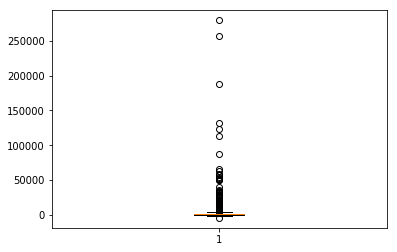

In [15]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

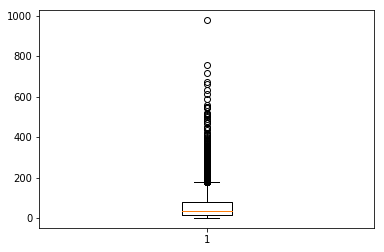

In [16]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

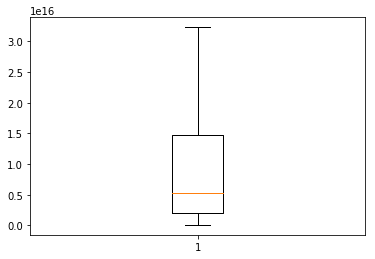

In [17]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [18]:
RFM.head(20)

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00
6,12353.0,4,89.00,204 days 19:03:00
7,12354.0,58,1079.40,232 days 23:39:00
8,12355.0,13,459.40,214 days 23:01:00
9,12356.0,59,2811.43,23 days 04:10:00
11,12358.0,19,1168.06,2 days 02:24:00


In [19]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standard_scaler.fit_transform(RFM_norm1)

array([[-1.07094871, -1.04161396,  2.13642223],
       [-0.3754979 ,  1.38529792, -0.28204953],
       [ 0.63170672,  1.33170234, -0.82162889],
       ..., 
       [-0.9510434 , -0.93247827,  0.73929711],
       [-0.80715703, -0.80314128, -0.92761769],
       [ 0.55976353,  1.43936613, -0.59038059]])

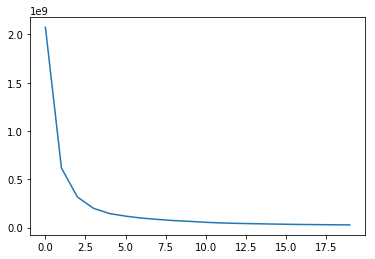

In [20]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [21]:
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [23]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,651.861634,49.602911,84.867983
1,1,1935.628973,89.782477,52.631420
2,2,1208.357731,68.507380,60.392989
3,3,225.822616,21.189707,147.131658
4,4,2888.302675,117.905759,41.052356


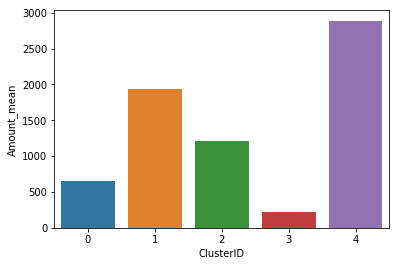

In [24]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)


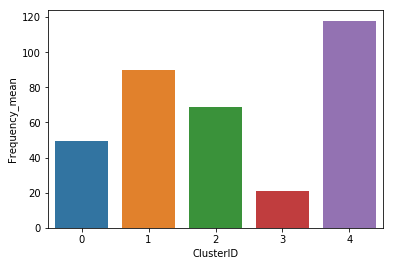

In [25]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

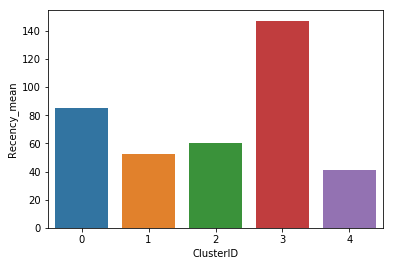

In [26]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

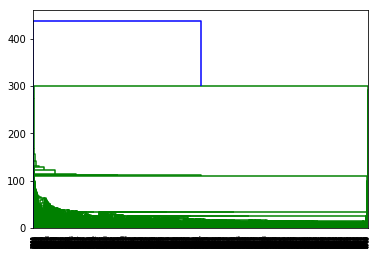

In [27]:
# heirarchical clustering
mergings = linkage(RFM_norm1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

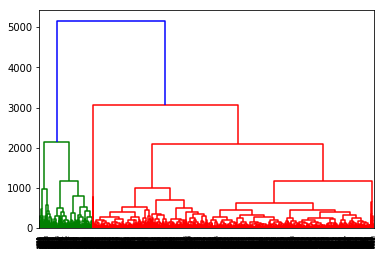

In [28]:
mergings = linkage(RFM_norm1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [29]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
RFM_hc = pd.concat([RFM, clusterCut], axis=1)
RFM_hc.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

In [30]:
#summarise
RFM_hc.Recency = RFM_hc.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

In [31]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,252.966698,22.707291,142.854733
1,1,1919.512313,92.709751,50.852608
2,2,867.327807,56.955626,73.369255
3,3,2990.865636,118.920530,44.165563
4,4,-1183.350000,7.800000,248.200000


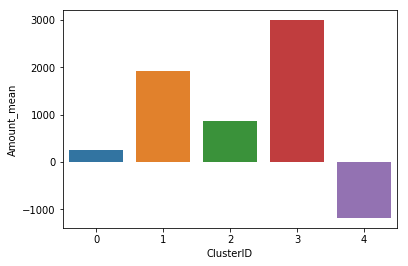

In [32]:
#plotting barplot
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

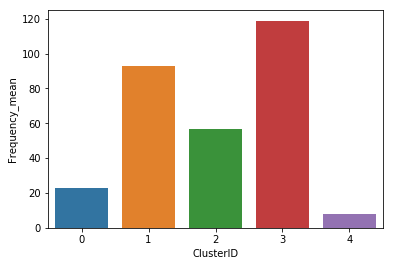

In [33]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

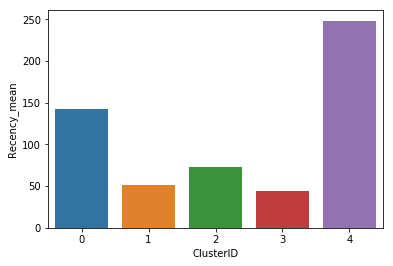

In [34]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)